In [ ]:
import numpy as np
from spec_id import Analyze_Stack_avgage,Likelihood_contours, Make_model_list,\
    Stack_spec_normwmean,Stack_model_normwmean,Best_fit_model,Model_fit_stack_UVB_normwmean
import matplotlib.pyplot as plt
import vtl.Constants as C
from vtl.Readfile import Readfile
from vtl.Get_sensitivity import Get_Sensitivity
from glob import glob
from astropy.io import fits, ascii
from astropy.table import Table
from scipy.interpolate import interp1d,interp2d
import os
import cPickle
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [ ]:
ids,speclist,lmass,rshift,rad,sig,comp=np.array(Readfile('lowmass_testlist.dat',is_float=False))
lmass,rshift,rad,sig,comp=np.array([lmass,rshift,rad,sig,comp]).astype(float)

metal=np.array([ 0.0020, 0.0025, 0.0031, 0.0039, 0.0049, 0.0061,  0.0068,  0.0077,  0.0085,  0.0096,  0.0106,
                  0.012, 0.0132, 0.014,  0.0150,  0.0164, 0.018,  0.019,  0.021,  0.024, 0.027, 0.03])
bcmetal=np.array([0.0001, 0.0004, 0.004, 0.008, 0.02])
age=np.arange(.5,6.1,.1)
tau=[0,8.0,8.93,9.21,9.37,9.5,9.6,9.66,9.73,9.8,9.84,9.88,9.93,9.97,10.0]
ntau=[8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]

M,A=np.meshgrid(metal,age)
BM,BA=np.meshgrid(bcmetal,age)

get spec and filter sensitivities

In [12]:
wv,fl,er=Stack_spec_normwmean(speclist,rshift,np.arange(3450,5300,10))

U = np.arange(wv[0], 4010, 10)
Usens = np.ones(len(U))
B = np.arange(4000, 4710, 10)
Bsens = np.ones(len(B))
V = np.arange(4700, wv[-1]+ 10, 10)
Vsens = np.ones(len(V))

# uwv,usens=Get_Sensitivity(140)
# bwv,bsens=Get_Sensitivity(141)
# vwv,vsens=Get_Sensitivity(142)

plot results

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.]


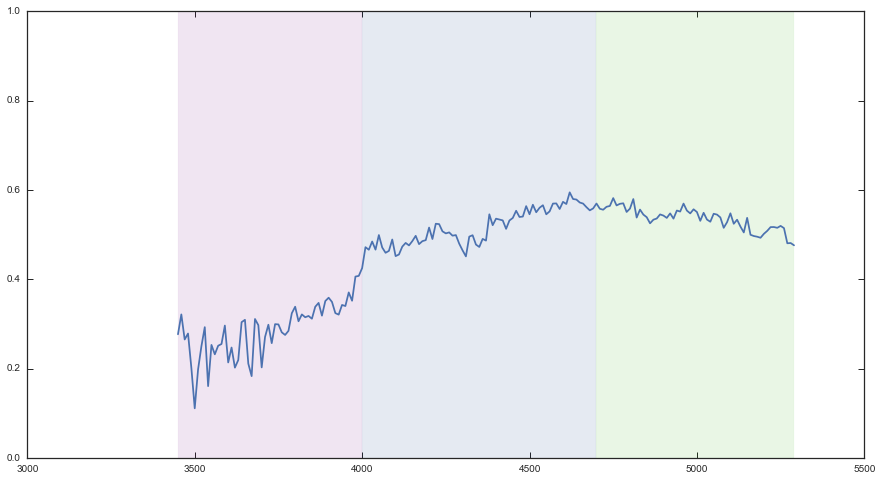

In [13]:
%matplotlib inline

print Usens

plt.figure(figsize=[15,8])
plt.plot(wv,fl*100)
plt.fill_between(U,np.zeros(len(U)),Usens,color='#750286',alpha=.1)
plt.fill_between(B,np.zeros(len(B)),Bsens,color='#093288',alpha=.1)
plt.fill_between(V,np.zeros(len(V)),Vsens,color='#2aad00',alpha=.1)
plt.show()
plt.close()

integrate to get photometric points

In [7]:
def Photo(wv,spec,er,filtwv,filtsens):
    h=C.h # planck constant erg s
    c=C.c          # speed of light cm s^-1
    atocm=C.angtocm

    wave=np.multiply(wv,atocm)
    nu=np.divide(c,wave)
    fnu=np.multiply(np.divide(c,np.square(nu)),spec)
    Fnu=interp1d(nu,fnu)
    ernu=np.multiply(np.divide(c,np.square(nu)),er)
    Ernu=interp1d(nu,ernu)
    

    filtnu=np.divide(c,np.multiply(filtwv,atocm))

    energy=np.divide(1/h,filtnu)
    top1=np.multiply(Fnu(filtnu),energy)
    top2=np.multiply(top1,filtsens)
    top=np.trapz(top2,filtnu)
    bottom1=np.multiply(filtsens,energy)
    bottom=np.trapz(bottom1,filtnu)
    photonu=top/bottom

    top1=np.multiply(Ernu(filtnu),energy)
    top2=np.multiply(top1,filtsens)
    top=np.trapz(top2,filtnu)
    bottom1=np.multiply(filtsens,energy)
    bottom=np.trapz(bottom1,filtnu)
    erphotonu=top/bottom

    tp=np.trapz(np.multiply(filtsens,filtwv), filtwv)
    bm=np.trapz(filtsens,filtwv)
    wave_eff=(tp/bm)

    photo=photonu*(c/(wave_eff*atocm)**2)
    photoer=erphotonu*(c/(wave_eff*atocm)**2)

    return wave_eff,photo,photoer

def Photo_model(wv,spec,filtwv,filtsens):
    h=C.h # planck constant erg s
    c=C.c          # speed of light cm s^-1
    atocm=C.angtocm

    wave=np.multiply(wv,atocm)
    nu=np.divide(c,wave)
    fnu=np.multiply(np.divide(c,np.square(nu)),spec)
    Fnu=interp1d(nu,fnu)

    filtnu=np.divide(c,np.multiply(filtwv,atocm))

    energy=np.divide(1/h,filtnu)
    top1=np.multiply(Fnu(filtnu),energy)
    top2=np.multiply(top1,filtsens)
    top=np.trapz(top2,filtnu)
    bottom1=np.multiply(filtsens,energy)
    bottom=np.trapz(bottom1,filtnu)
    photonu=top/bottom

    tp=np.trapz(np.multiply(filtsens,filtwv), filtwv)
    bm=np.trapz(filtsens,filtwv)
    wave_eff=(tp/bm)

    photo=photonu*(c/(wave_eff*atocm)**2)

    return photo

In [14]:
U_weff,U_phot,U_photer=Photo(wv,fl,er,U,Usens)
B_weff,B_phot,B_photer=Photo(wv,fl,er,B,Bsens)
V_weff,V_phot,V_photer=Photo(wv,fl,er,V,Vsens)

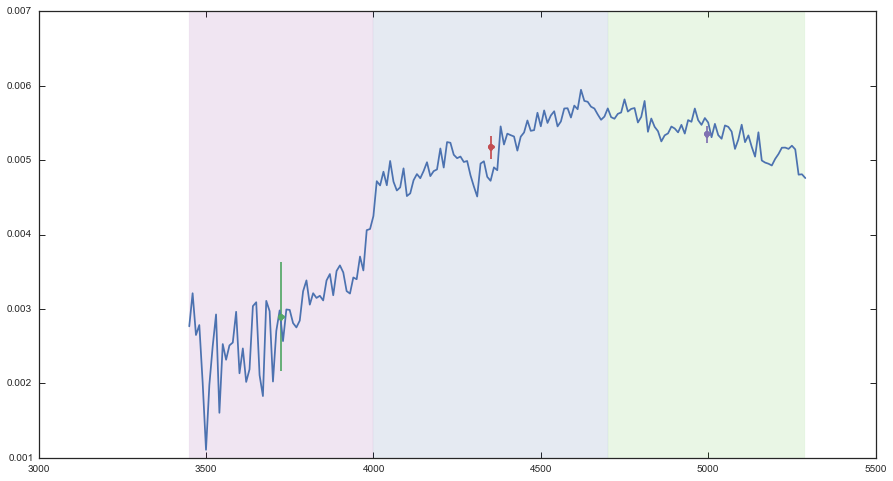

In [16]:
gphot=np.array([U_phot,B_phot,V_phot])
gphot_er=np.array([U_photer,B_photer,V_photer])

plt.figure(figsize=[15,8])
plt.plot(wv,fl)
plt.errorbar(U_weff,U_phot,U_photer,fmt='o')
plt.errorbar(B_weff,B_phot,B_photer,fmt='o')
plt.errorbar(V_weff,V_phot,V_photer,fmt='o')
plt.fill_between(U,np.zeros(len(U)),Usens,color='#750286',alpha=.1)
plt.fill_between(B,np.zeros(len(B)),Bsens,color='#093288',alpha=.1)
plt.fill_between(V,np.zeros(len(V)),Vsens,color='#2aad00',alpha=.1)
plt.ylim(0.001,0.007)
plt.show()
plt.close()

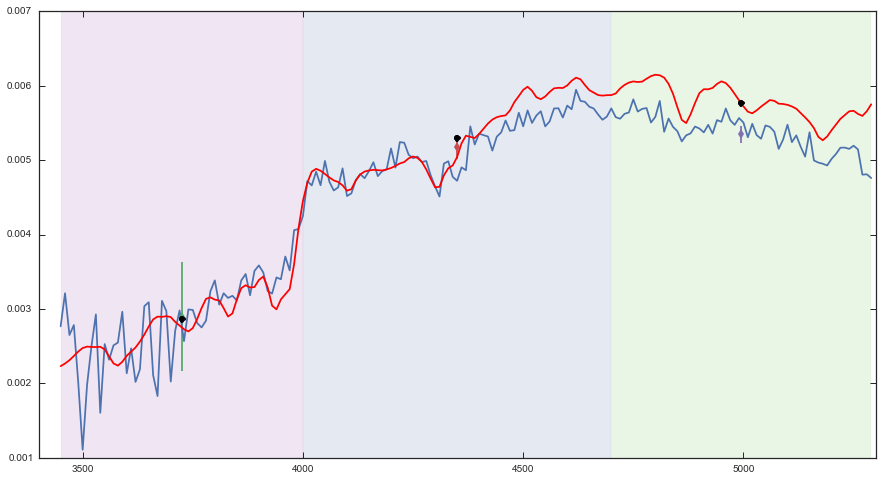

In [25]:
mlist=Make_model_list(ids,0.024,2.0,8.3,rshift)
mwv,mfl=Stack_model_normwmean(speclist,mlist,rshift,np.arange(3450,5300,10))

U_m_phot=Photo_model(wv,mfl,U,Usens)
B_m_phot=Photo_model(wv,mfl,B,Bsens)
V_m_phot=Photo_model(wv,mfl,V,Vsens)

plt.figure(figsize=[15,8])
plt.plot(wv,fl)
plt.plot(mwv,mfl,'r')
plt.errorbar(U_weff,U_phot,U_photer,fmt='d')
plt.errorbar(B_weff,B_phot,B_photer,fmt='d')
plt.errorbar(V_weff,V_phot,V_photer,fmt='d')
plt.plot(U_weff,U_m_phot,'ko')
plt.plot(B_weff,B_m_phot,'ko')
plt.plot(V_weff,V_m_phot,'ko')
plt.fill_between(U,np.zeros(len(U)),Usens,color='#750286',alpha=.1)
plt.fill_between(B,np.zeros(len(B)),Bsens,color='#093288',alpha=.1)
plt.fill_between(V,np.zeros(len(V)),Vsens,color='#2aad00',alpha=.1)
plt.ylim(0.001,0.007)
plt.xlim(3400,5300)
plt.show()
plt.close()

In [ ]:
metal_test=np.array([0.0085, 0.019])
age_test=[2.0,3.0,4.0]
ntau_test=[0,8.0, 8.3, 8.48]

Mt,At=np.meshgrid(metal_test,age_test)


Model_fit_stack_UVB_normwmean(speclist,tau,metal,age,rshift,ids,np.arange(3450,5300,10),'lmass_mar8_uvb_fit',
                          'lmass_mar7_spec',res=10,fsps=True)

bfm,bfa,bft=Best_fit_model('chidat/lmass_mar8_uvb_fit_chidata.fits',metal,age,tau)
Pru, bfage, bfmetal= Analyze_Stack_avgage('chidat/lmass_mar8_uvb_fit_chidata.fits',np.array(tau),
                                          metal,age,age_conv='tau_scale_ntau.dat')
onesig,twosig=Likelihood_contours(age,metal,Pr)
levels=np.array([twosig,onesig])
print levels
# levels=np.array([6.18360513, 15.93924044])

plt.figure(figsize=[8,8])
plt.contour(M,A,Pru,levels,colors='k',linewidths=2)
plt.contourf(M,A,Pru,40,cmap=colmap)
plt.plot(bfmetal,bfage,'cp',label='\nBest fit\nt=%s Gyrs\nZ=%s Z$_\odot$' % (bfage,np.round(bfmetal/0.019,2)))
plt.xticks([0,.005,.01,.015,.02,.025,.03],np.round(np.array([0,.005,.01,.015,.02,.025,.03])/0.02,2))
plt.tick_params(axis='both', which='major', labelsize=17)
plt.gcf().subplots_adjust(bottom=0.16)
plt.minorticks_on()
plt.xlabel('Metallicity (Z$_\odot$)')
plt.ylabel('Age (Gyrs)')
plt.legend()
plt.show()
plt.close()

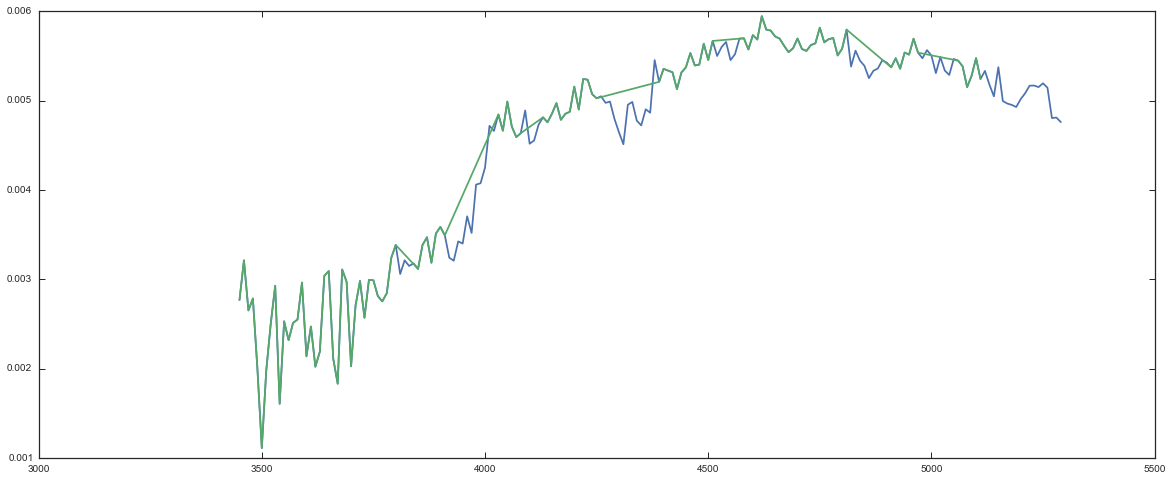

In [6]:
%matplotlib inline

wv,fl,er=Stack_spec_normwmean(speclist,rshift,np.arange(3450,5300,10))
IDM=[]
for i in range(len(wv)):
    if wv[0]<=wv[i]<=3800 or 3850<=wv[i]<=3910 or 4030<=wv[i]<=4080 or 4125<=wv[i]<=4250 or 4385<=wv[i]<=4515 or 4570<=wv[i]<=4810 or 4910<=wv[i]<=4975 or 5055<=wv[i]<=5110:
        IDM.append(i)
        
plt.figure(figsize=[20,8])
plt.plot(wv,fl)
plt.plot(wv[IDM],fl[IDM])
plt.show()
plt.close()